In [1]:
import glob
import sys
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import scipy as spy
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import ssl
import pickle, json
import src.main as lc
from src.models.AlexNet import AlexNet
import src.compression.deltaCompress as lc_compress
from src.models.AlexNet_LowRank import getBase, AlexNet_LowRank, load_sd_decomp
from src.utils.utils import evaluate_accuracy, lazy_restore, evaluate_compression

In [2]:
HDFP = "/volumes/Ultra Touch" # Load HHD

def data_loader():
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

    trainset = datasets.MNIST(root='./data', train=True,
                                          download=True, transform=transform)
    trainset.data = trainset.data
    trainset.targets = trainset.targets
    trainloader = torch.utils.data.DataLoader(trainset, batch_size = 32,
                                              shuffle=False, num_workers=2)

    testset = datasets.MNIST(root='./data', train=False,
                                         download=True, transform=transform)
    testset.data = testset.data
    testset.targets = testset.targets
    testloader = torch.utils.data.DataLoader(testset, batch_size = 32,
                                             shuffle=False, num_workers=2)
    return trainloader, testloader

In [3]:
# Bypass using SSL unverified
ssl._create_default_https_context = ssl._create_unverified_context
# MNIST dataset 
train_loader, test_loader = data_loader()

SAVE_LOC = HDFP + "/lobranch/lobranch"
SAVE_LOC_FULL = HDFP + "/lobranch/full"
if not os.path.exists(SAVE_LOC):
    os.makedirs(SAVE_LOC)
if not os.path.exists(SAVE_LOC_FULL):
    os.makedirs(SAVE_LOC_FULL)

# Rank-100

In [4]:
DECOMPOSED_LAYERS = ["classifier.1.weight", "classifier.4.weight"]

# Set up weights for original AlexNet model
original = AlexNet()
model_original = AlexNet()

# Load from "branch point"
BRANCH_LOC = HDFP + "/sim-test/alexnet/full/model-0.522.pt"
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))

w, b = getBase(model_original)
model = AlexNet_LowRank(w, b)
load_sd_decomp(torch.load(BRANCH_LOC), model, DECOMPOSED_LAYERS)
learning_rate = 0.01
rank = 3
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer_full = torch.optim.SGD(model_original.parameters(), lr = learning_rate)


In [5]:
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []

for epch in range(1):
    for i, data in enumerate(train_loader, 0):
        print("Epoch: {}, Iteration: {}".format(epch, i))

        if i == 30: # end test
            break

        if i == 0: # first iteration, create baseline model
            base, base_decomp = lc.extract_weights(model, SAVE_LOC, DECOMPOSED_LAYERS)
            print("testing on first load:")
            evaluate_accuracy(model, test_loader)
        else:
            # Delta-compression
            delta, new_base, decomp_delta, new_base_decomp, bias = lc.generate_delta(base, 
                                                            base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
            compressed_delta, compressed_dcomp_delta = lc.compress_delta(delta, decomp_delta)
            
            # Saving checkpoint
            lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, i, SAVE_LOC)
  
            base = new_base # Replace base with latest for delta to accumulate.
            base_decomp = new_base_decomp
        

        if i != 0:
            print("testing on decomposed alexnet:")
            decomposed_full_accuracy.append(evaluate_accuracy(model, test_loader))
            print("testing on checkpointed alexnet:")
            restored_model = lazy_restore(base, base_decomp, bias, AlexNet(), 3, 
                                          original.state_dict(), DECOMPOSED_LAYERS)
            restored_accuracy.append(evaluate_accuracy(restored_model, test_loader))

        torch.save(model_original.state_dict(), SAVE_LOC_FULL + "/base_model_{}.pt".format(i))
        
        if i != 0:
            # Evaluation
            print("testing on original alexnet:")
            full_accuracy.append(evaluate_accuracy(model_original, test_loader))
        
        # ==========================
        # Training on Low-Rank Model
        # ==========================

        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs,labels)
        loss.backward()
        optimizer.step()
            
        # ======================
        # Training on Full Model
        # ======================

        # Zero the parameter gradients
        optimizer_full.zero_grad()

        # Forward + backward + optimize
        outputs_full = model_original(inputs)
        loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
        loss_full.backward()
        optimizer_full.step()

Epoch: 0, Iteration: 0
testing on first load:
model accuracy: 0.5219
Epoch: 0, Iteration: 1
Saving Checkpoint lc_checkpoint_1.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accuracy: 0.6542
testing on checkpointed alexnet:
model accuracy: 0.6505
testing on original alexnet:
model accuracy: 0.6357
Epoch: 0, Iteration: 2
Saving Checkpoint lc_checkpoint_2.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accuracy: 0.7102
testing on checkpointed alexnet:
model accuracy: 0.688
testing on original alexnet:
model accuracy: 0.694
Epoch: 0, Iteration: 3
Saving Checkpoint lc_checkpoint_3.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accuracy: 0.6858
testing on checkpointed alexnet:
model accuracy: 0.6737
testing on original alexnet:
model accuracy: 0.6286
Epoch: 0, Iteration: 4
Saving Checkpoint lc_checkpoint_4.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accura

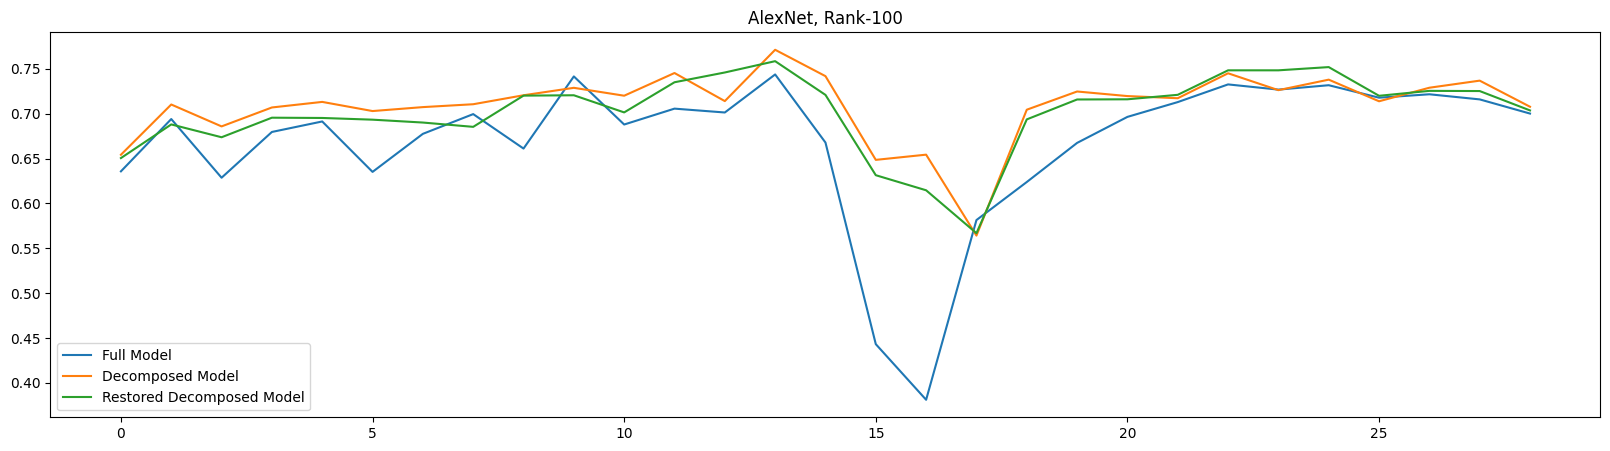

In [6]:
plt.figure(figsize = (20, 5))
plt.title("AlexNet, Rank-100")
plt.plot(full_accuracy, label = "Full Model")
plt.plot(decomposed_full_accuracy, label = "Decomposed Model")
plt.plot(restored_accuracy, label = "Restored Decomposed Model")
plt.legend()
plt.show()

In [7]:
compressed_size = sum(os.path.getsize(SAVE_LOC + "/" + f) 
                      for f in os.listdir(SAVE_LOC))
uncompressed_size = sum(os.path.getsize(SAVE_LOC_FULL + "/" + f) 
                        for f in os.listdir(SAVE_LOC_FULL))
a, b = evaluate_compression(uncompressed_size, compressed_size)

print("LC-Checkpoint (B. Experiment)")
print("Compression Ratio: 427.794%, Space Savings: 76.576%")
print("LoRA + LC-Checkpoint (Rank-100)")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

LC-Checkpoint (B. Experiment)
Compression Ratio: 427.794%, Space Savings: 76.576%
LoRA + LC-Checkpoint (Rank-100)
Compression Ratio: 44772.634%, Space Savings: 99.777%


# Rank-3

In [8]:
DECOMPOSED_LAYERS = ["classifier.1.weight", "classifier.4.weight"]

# Set up weights for original AlexNet model
original = AlexNet()
model_original = AlexNet()

# Load from "branch point"
BRANCH_LOC = HDFP + "/sim-test/alexnet/full/model-0.522.pt"
original.load_state_dict(torch.load(BRANCH_LOC))
model_original.load_state_dict(torch.load(BRANCH_LOC))

w, b = getBase(model_original)
model = AlexNet_LowRank(w, b, rank = 3)
load_sd_decomp(torch.load(BRANCH_LOC), model, DECOMPOSED_LAYERS)
learning_rate = 0.01
rank = 3
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer_full = torch.optim.SGD(model_original.parameters(), lr = learning_rate)

In [9]:
full_accuracy = []
decomposed_full_accuracy = []
restored_accuracy = []

for epch in range(1):
    for i, data in enumerate(train_loader, 0):
        print("Epoch: {}, Iteration: {}".format(epch, i))

        if i == 30: # end test
            break

        if i == 0: # first iteration, create baseline model
            base, base_decomp = lc.extract_weights(model, SAVE_LOC, DECOMPOSED_LAYERS)
            print("testing on first load:")
            evaluate_accuracy(model, test_loader)
        else:
            # Delta-compression
            delta, new_base, decomp_delta, new_base_decomp, bias = lc.generate_delta(base, 
                                                            base_decomp, model.state_dict(), DECOMPOSED_LAYERS)
            compressed_delta, compressed_dcomp_delta = lc.compress_delta(delta, decomp_delta)
            
            # Saving checkpoint
            lc.save_checkpoint(compressed_delta, compressed_dcomp_delta, bias, i, SAVE_LOC)
  
            base = new_base # Replace base with latest for delta to accumulate.
            base_decomp = new_base_decomp
        

        if i != 0:
            print("testing on decomposed alexnet:")
            decomposed_full_accuracy.append(evaluate_accuracy(model, test_loader))
            print("testing on checkpointed alexnet:")
            restored_model = lazy_restore(base, base_decomp, bias, AlexNet(), 3, 
                                          original.state_dict(), DECOMPOSED_LAYERS)
            restored_accuracy.append(evaluate_accuracy(restored_model, test_loader))

        torch.save(model_original.state_dict(), SAVE_LOC_FULL + "/base_model_{}.pt".format(i))
        
        if i != 0:
            # Evaluation
            print("testing on original alexnet:")
            full_accuracy.append(evaluate_accuracy(model_original, test_loader))
        
        # ==========================
        # Training on Low-Rank Model
        # ==========================

        # Get the inputs and labels
        inputs, labels = data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs,labels)
        loss.backward()
        optimizer.step()
            
        # ======================
        # Training on Full Model
        # ======================

        # Zero the parameter gradients
        optimizer_full.zero_grad()

        # Forward + backward + optimize
        outputs_full = model_original(inputs)
        loss_full = torch.nn.functional.cross_entropy(outputs_full,labels)
        loss_full.backward()
        optimizer_full.step()

Epoch: 0, Iteration: 0
testing on first load:
model accuracy: 0.5219
Epoch: 0, Iteration: 1
Saving Checkpoint lc_checkpoint_1.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accuracy: 0.6545
testing on checkpointed alexnet:
model accuracy: 0.6513
testing on original alexnet:
model accuracy: 0.6523
Epoch: 0, Iteration: 2
Saving Checkpoint lc_checkpoint_2.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accuracy: 0.7102
testing on checkpointed alexnet:
model accuracy: 0.7174
testing on original alexnet:
model accuracy: 0.7041
Epoch: 0, Iteration: 3
Saving Checkpoint lc_checkpoint_3.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accuracy: 0.6899
testing on checkpointed alexnet:
model accuracy: 0.6886
testing on original alexnet:
model accuracy: 0.6444
Epoch: 0, Iteration: 4
Saving Checkpoint lc_checkpoint_4.pt @ /volumes/Ultra Touch/lobranch/lobranch
testing on decomposed alexnet:
model accu

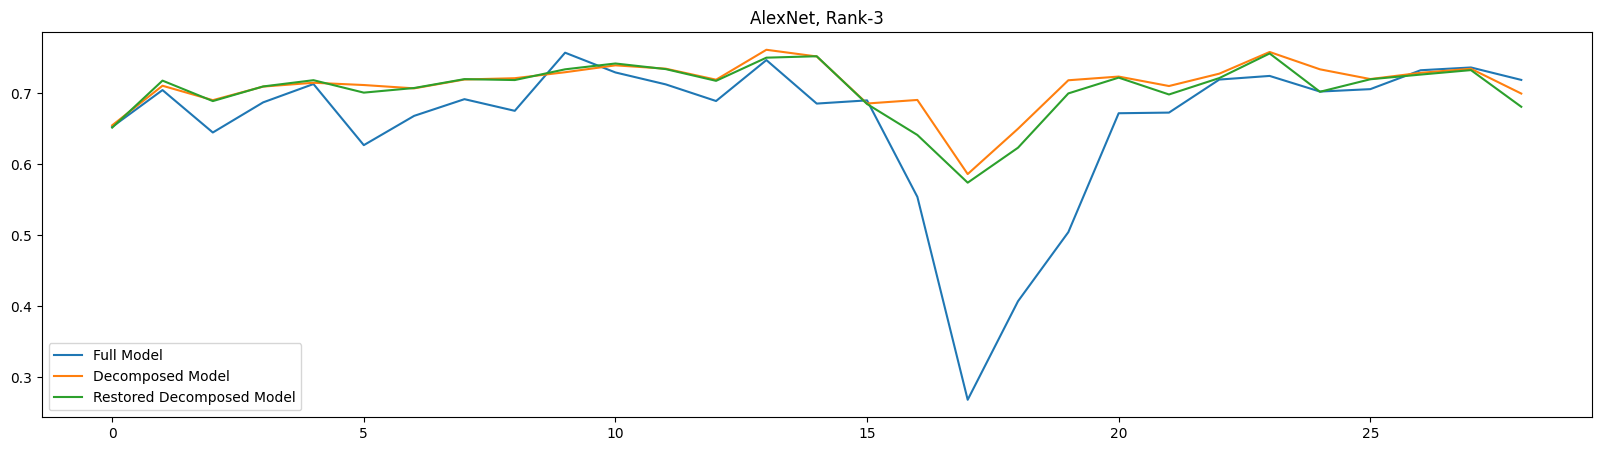

In [10]:
plt.figure(figsize = (20, 5))
plt.title("AlexNet, Rank-3")
plt.plot(full_accuracy, label = "Full Model")
plt.plot(decomposed_full_accuracy, label = "Decomposed Model")
plt.plot(restored_accuracy, label = "Restored Decomposed Model")
plt.legend()
plt.show()

In [11]:
compressed_size = sum(os.path.getsize(SAVE_LOC + "/" + f) 
                      for f in os.listdir(SAVE_LOC))
uncompressed_size = sum(os.path.getsize(SAVE_LOC_FULL + "/" + f) 
                        for f in os.listdir(SAVE_LOC_FULL))
a, b = evaluate_compression(uncompressed_size, compressed_size)

print("LC-Checkpoint (B. Experiment)")
print("Compression Ratio: 427.794%, Space Savings: 76.576%")
print("LoRA + LC-Checkpoint (Rank-3)")
print("Compression Ratio: {}%, Space Savings: {}%".format(a, b))

LC-Checkpoint (B. Experiment)
Compression Ratio: 427.794%, Space Savings: 76.576%
LoRA + LC-Checkpoint (Rank-3)
Compression Ratio: 75683.75%, Space Savings: 99.868%
